In [1]:
# HELPER FUNCTIONS

def load_genes(filename, delimiter='\t', column=0, skip_rows=0):
    gene_list = []
    gene_dict = {}

    with open(filename) as f:
        for iL in range(skip_rows):
            f.readline()
        for l in f:
            gene = l.strip('\n').split(delimiter)[column]
            gene = gene.replace("/", "\/")
            if gene in gene_dict:
                gene_dict[gene] += 1
                gene_list.append(gene + '__' + str(gene_dict[gene]))
                if gene_dict[gene] == 2:
                    i = gene_list.index(gene)
                    gene_list[i] = gene + '__1'
            else: 
                gene_dict[gene] = 1
                gene_list.append(gene)
    return gene_list

def load_text(file_data,delim='\t'):
    X_data = []
    X_row = []
    X_col = []

    start_column = -1
    start_row = -1
    for row_ix, dat in enumerate(file_data):
        dat = dat.strip('\n').split(delim)

        if start_row == -1:
            current_col = 0
            found_float = False
            while not found_float and current_col < len(dat):
                try: 
                    tmp = float(dat[current_col])
                    
                    try:
                        rowdat = np.array(map(float, dat[current_col:]))
                        ncol = len(rowdat)
                        col_ix = np.nonzero(rowdat)[0]

                        found_float = True
                        start_row = row_ix
                        start_column = current_col

                        X_col.extend(col_ix)
                        X_row.extend([row_ix - start_row] * len(col_ix))
                        X_data.extend(rowdat[col_ix])

                    except:
                        current_col += 1

                except:
                    current_col += 1
        else:
            try:
                rowdat = np.array(map(float, dat[start_column:]))
                if len(rowdat) != ncol:
                    return 'ERROR: Rows have different numbers of numeric columns.'
                col_ix = np.nonzero(rowdat)[0]
                X_col.extend(col_ix)
                X_row.extend([row_ix - start_row] * len(col_ix))
                X_data.extend(rowdat[col_ix])
            except:
                return 'ERROR: Rows have different numbers of numeric columns.'

    if start_row == -1:
        return 'ERROR: no numeric values found'

    nrow = row_ix - start_row + 1
    E = scipy.sparse.coo_matrix((X_data, (X_row, X_col)), dtype=float, shape=(nrow, ncol)).tocsc()
    
    return E

def file_opener(filename):
    fileData = open(filename)
    if filename.endswith('.gz'):
        import gzip
        outData = gzip.GzipFile(fileobj = fileData, mode = 'rb')
    elif filename.endswith('.zip'):
        import zipfile
        zipData = zipfile.ZipFile(fileData, 'r')
        fnClean = filename.strip('/').split('/')[-1][:-4]
        outData = zipData.open(fnClean)
    else:
        outData = fileData
    return outData


In [2]:
%matplotlib inline

from collections import defaultdict
from collections import defaultdict
import scipy
import traceback
import os
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()  # for plot styling

import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#LOAD DATA

input_path = 'filtered_gene_bc_matrices/zv10_gtf89_cloche_gfp/'

if os.path.isfile(input_path + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_path + '/matrix.npz')
else:
    E = scipy.io.mmread(input_path + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_path + '/matrix.npz', E, compressed=True)

    

gene_list = np.array(load_genes(input_path + 'genes.tsv',column = 1))
#print(counts_list.shape)
#print('Matrix shape:'+str(E.shape))
#print('Genelist size:'+str(len(gene_list)))


In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [152]:
### THRESHOLDING ####
def threshold(E,min_val,max_val):
    print('CellCount min:'+str(min_val)+' max:'+str(max_val))
    # plotting total counts pre-thresholding
    total_counts = np.sum(E, axis=1).A[:,0]
    tmpfilt = np.nonzero((total_counts <= max_val)&(total_counts >= min_val))[0]
    print('Pre-filter: %i barcodes' %E.shape[0])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts, bins=np.logspace(0, 6, 100))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    # applying filter
    Efilt = E[tmpfilt,:]
    print('Post-filter: %i barcodes' %Efilt.shape[0])
    total_counts_filt = np.sum(Efilt, axis=1).A[:,0]
    
    # plotting post filter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.logspace(0, 6, 100))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    return [Efilt,tmpfilt]

    
    
    

In [23]:
def GeneCount(E,min_val,max_val):
    print('GeneCount min:'+str(min_val)+' max:'+str(max_val))
    # plotting total counts pre-thresholding
    total_counts = np.sum(E, axis=0).A[0,:]
    tmpfilt = np.nonzero((total_counts <= max_val)&(total_counts >= min_val))[0]
    print('Pre-filter: %i barcodes' %E.shape[1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts, bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    # applying filter
    Efilt = E[:,tmpfilt]
    print('Post-filter: %i barcodes' %Efilt.shape[1])
    total_counts_filt = np.sum(Efilt, axis=0).A[0,:]
    
    # plotting post filter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    return [Efilt,tmpfilt]


GeneCount min:2 max:20000
Pre-filter: 25260 barcodes
Post-filter: 17477 barcodes


<1640x17477 sparse matrix of type '<class 'numpy.int64'>'
	with 3693898 stored elements in Compressed Sparse Column format>

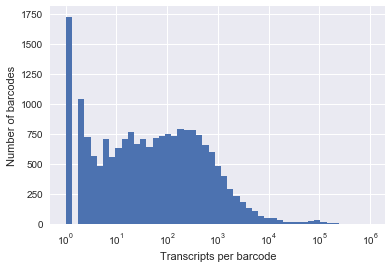

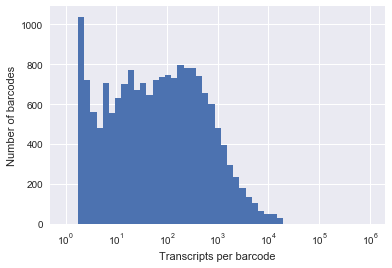

In [145]:
GeneCount(E,2,20000)[0]

In [6]:
### MITO FRACTION ###

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('mt-')]
list1 = [gene_list[i] for i in mt_ix]
#print(mt_ix)


In [158]:
def mito_frac(E,max_mt):
    #max_mt = 0.05
    print('Mito fraction filter: '+str(max_mt))
    
    #plotting the initial mito fraction
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')
    mito_frac = np.sum(E[:,mt_ix], axis=1).A[:,0] / np.sum(E, axis=1,dtype=float).A[:,0]
    ax.hist(mito_frac, cumulative=False, 
            bins=np.linspace(0, 0.1, 100))

    #setting up filter
    tmpfilt = np.nonzero(mito_frac <= max_mt)[0]
    ax.plot([max_mt,max_mt],ax.get_ylim());
    print('Pre-filter: %i barcodes' %E.shape[0])
    Efilt = E[tmpfilt,:]
    print('Post-filter: %i barcodes' %Efilt.shape[0])
    
    #plotting post filter mito fraction
    total_counts_filt = mito_frac[tmpfilt]
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.linspace(0, 0.1, 100))

    return [Efilt,tmpfilt]
    

Mito fraction filter: 0.04
Pre-filter: 1640 barcodes
Post-filter: 1636 barcodes


<1636x25260 sparse matrix of type '<class 'numpy.int64'>'
	with 3918556 stored elements in Compressed Sparse Column format>

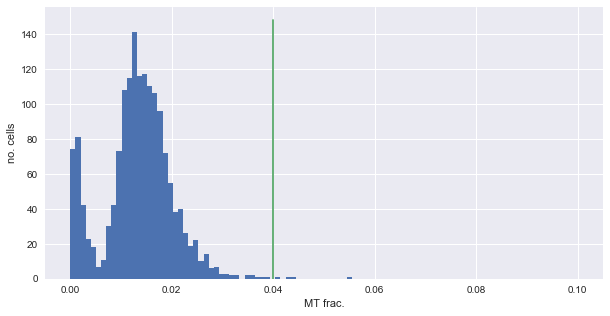

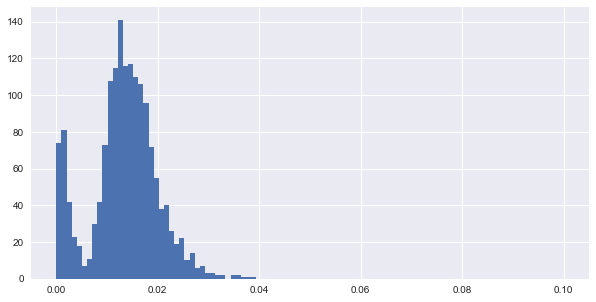

In [159]:
mito_frac(E,0.04)[0]

In [9]:
#mito_frac = np.sum(E[:,mt_ix], axis=1).A[:,0] / np.sum(E, axis=1,dtype=float).A[:,0]

In [10]:
# min_tot = 5000
# max_tot = 12000
# total_counts = np.sum(E, axis=1).A[:,0]

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.hist(total_counts, bins=np.logspace(0, 6, 50))
# ax.set_xscale('log')
# ax.set_xlabel('Transcripts per barcode')
# ax.set_ylabel('Number of barcodes')

    
# ax.plot([min_tot,min_tot],ax.get_ylim());
#     #title(s)

# ix = total_counts >= min_tot
# #print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])

In [11]:

# print('Pre-filter: %i barcodes' %E.shape[0])
# #D[s]['cell_index'] = np.arange(D[s]['E'].shape[0])
# tmpfilt = np.nonzero(total_counts >= min_tot)[0]

# #D[s] = filter_dict(D[s], tmpfilt)
# print('Post-filter: %i barcodes' %E.shape[0])
# #print(total_counts)
# #print(tmpfilt)
# #print(type(E))
# Efilt = E[tmpfilt,:]
# print(Efilt.shape)
# print(type(tmpfilt))
# total_counts2 = np.sum(Efilt, axis=1).A[:,0]
# #tmpfilt2 = np.nonzero(total_counts2 <= max_tot)[0]
# #Efilt2 = Efilt[tmpfilt2,:]
# tmpfilt3 = np.nonzero((total_counts <= max_tot)&(total_counts >= min_tot))[0]
# #tmpfilt5 = np.nonzero(total_counts >= min_tot)[0]
# #tmpfilt4 = tmpfilt3.intersect(tmpfilt)
# Efilt4 = E[tmpfilt3,:]
# print(E[tmpfilt3,:].shape)

# #del tmpfilt
# #print(Efilt2.shape)

In [12]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# total_counts_filt = np.sum(Efilt4, axis=1).A[:,0]
# #print(total_counts_filt)
# #print(tmpfilt)
# ax.hist(total_counts_filt, bins=np.logspace(0, 6, 50))
# ax.set_xscale('log')
# ax.set_xlabel('Transcripts per barcode')
# ax.set_ylabel('Number of barcodes')

    
# ax.plot([min_tot,min_tot],ax.get_ylim());

In [26]:
E

<1640x25260 sparse matrix of type '<class 'numpy.int64'>'
	with 3922937 stored elements in Compressed Sparse Column format>

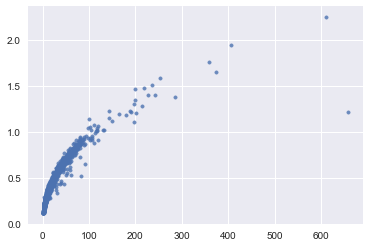

In [101]:
m = np.mean(E,axis=1)
#v = np.var(E,axis=0)
E2 = E.copy()
E2.data **= 2
m2 = np.mean(E2,axis=1)
#print(type(m2[0]))
#m2 = m2.toarray()
m3 = np.square(m)
m4 = m2-m3
m4 = m4.tolist()
m=m.tolist()
plt.scatter(m4, m, alpha=0.8,marker = '.', cmap='viridis')


In [153]:
### THRESHOLDING ####
def thresholdLog(E,min_val,max_val):
    print('CellCount min:'+str(min_val)+' max:'+str(max_val))
    # plotting total counts pre-thresholding
    total_counts = np.sum(E, axis=1).A[:,0]
    tmpfilt = np.nonzero((total_counts <= max_val)&(total_counts >= min_val))[0]
    print('Pre-filter: %i barcodes' %E.shape[0])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    print(total_counts)
    ax.hist(np.log(total_counts+1), bins=np.linspace(5, 14, 100))
    #ax.set_xscale('log')
    #ax.set_xlabel('Transcripts per barcode')
    #ax.set_ylabel('Number of barcodes')

    # applying filter
    Efilt = E[tmpfilt,:]
    print('Post-filter: %i barcodes' %Efilt.shape[0])
    total_counts_filt = np.sum(Efilt, axis=1).A[:,0]
    
    # plotting post filter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(np.log(total_counts_filt), bins=np.linspace(5, 14, 100))
    #ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    return [Efilt,tmpfilt]


    
    
    

CellCount min:100 max:20000
Pre-filter: 1640 barcodes
[19010 10104 13324 ...  4910 11706 10775]
Post-filter: 1540 barcodes


[<1540x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 3521249 stored elements in Compressed Sparse Column format>,
 array([   0,    1,    2, ..., 1637, 1638, 1639], dtype=int64)]

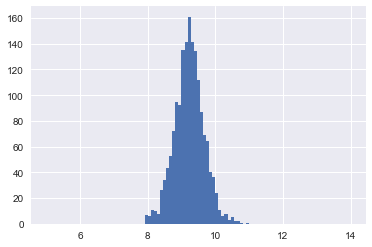

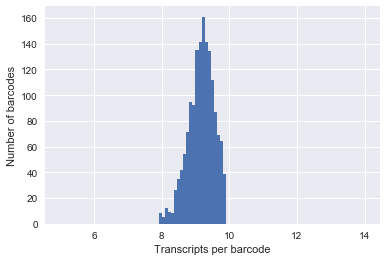

In [154]:
thresholdLog(E,100,20000)

CellCount min:100 max:20000
Pre-filter: 1640 barcodes
Post-filter: 1540 barcodes


[<1540x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 3521249 stored elements in Compressed Sparse Column format>,
 array([   0,    1,    2, ..., 1637, 1638, 1639], dtype=int64)]

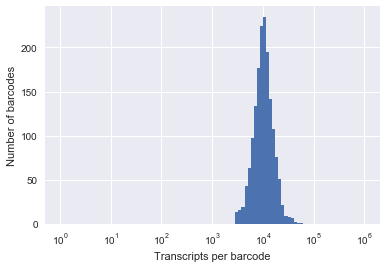

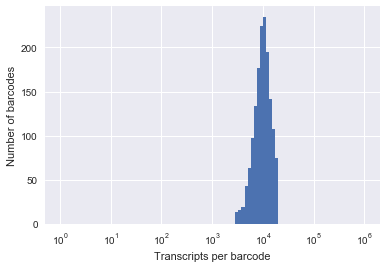

In [155]:
threshold(E,100,20000)